# **Art Classifier**

## **Non Structured Data**

This project has been done by:

|Name                    |Email                              |
|------------------------|-----------------------------------|
|Jorge Ayuso Martínez    |jorgeayusomartinez@alu.comillas.edu|
|Carlota Monedero Herranz|carlotamoh@alu.comillas.edu        |
|José Manuel Vega Gradit |josemanuel.vega@alu.comillas.edu   |

First of all, let's load the required libraries in order to run the code:

# Load dependencies

In [51]:
import os
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

Now let's see how our data is structured:

In [52]:
# Root folder
base_dir = "./data"

In [53]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [54]:
for path in os.walk(base_dir):
    for folder in path[1]:
        if ".ipynb_checkpoints" in folder:
            os.rmdir(os.path.join(path[0], folder))

Let's also see how many images there are for each class in the training, validation and test set.

In [55]:
# Number of classes
n_classes = len(os.listdir(train_dir))
print(f"Number of classes: {n_classes}")

# Get existing classes
classes = os.listdir(train_dir)
print("Existing classes:\n")
classes

Number of classes: 4
Existing classes:



['Baroque', 'Realism', 'Renaissance', 'Romanticism']

In [56]:
# Training
print("Number of images per class in Training set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(train_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Training set:
Baroque: 4000
Realism: 4000
Renaissance: 4000
Romanticism: 4000


In [57]:
# Validation
print("Number of images per class in Validation set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(validation_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Validation set:
Baroque: 500
Realism: 500
Renaissance: 500
Romanticism: 500


In [58]:
# Test
print("Number of images per class in Test set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(test_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Test set:
Baroque: 500
Realism: 500
Renaissance: 500
Romanticism: 500


We'll also create the directory, if not created yet, where the models will be saved:

In [59]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

## **2. Alex model**

Once of the things that we wanted to evaluate is whether a significant change in model architecture would help us improve performance on the dataset. Keeping this in mind, we researched some famous model architectures and wanted to evaluate how one of the most promising ones would help us solve this classification problem. Due to lack of time and resources, we could not try other potential candidates, but we will make sure to evaluate them on the transfer learning notebook.

### 1.1. Model structure

Based on this [paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0248414#sec014) and this [paper](https://www.sciencedirect.com/science/article/abs/pii/S0957417418304421?via%3Dihub) we found that the optimal architecture for this particular task is the one resembling [CaffeNet](https://dl.acm.org/doi/10.1145/2647868.2654889), an architecture based on [Alexnet](https://paperswithcode.com/paper/imagenet-classification-with-deep) where pooling is done prior to normalization. This network consist of 5 convolutional layers using ReLu as activation function, 3 max-pooling layers, 2 normalization layers, 2 fully connected layers and 1 softmax layer (used as output layer). 2. Each convolutional layer consists of convolutional filters and a nonlinear activation function ReLU.

We will try to emulate the this architecture for our problem, but reducing the number of filters to be applied in each of the layers, as this network was initially design for a classification problem involving 1000 different classes. We additionally did not include normalization layers for the moment, as we wanted to evaluate if higher accuracies could be reached using this architecture as base.

In [60]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                       )
)

# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 5th Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))

# Fully-connected layers
model.add(layers.Flatten())

# 1st Dense layer
model.add(layers.Dense(512, activation='relu'))
# 1st normalization layer
model.add(layers.Dropout(0.2))
# 2nd Dense layer
model.add(layers.Dense(512, activation='relu'))
# Output layer
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [61]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 conv2d_18 (Conv2D)          (None, 58, 58, 128)      

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [62]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 1.2. Data preprocessing

In addition to using normalization techniques and adding complexity to our global architecture, we want to implement data augmentation techniques, so that our network can have an increase amount of data to learn from. Keeping this in mind, we suggest the following transformations to our data:

In [63]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest' # filling strategy
)
test_datagen = ImageDataGenerator(rescale=1/.255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=128,
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=128,
        class_mode='categorical',
        shuffle=False
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


### 1.3. Training

We can now train this improved version of our model and see if it improves performance upon the first version. We will still implement EarlyStopping to make sure we avoid *overfitting* as much as possible.

In [64]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(os.path.join("models", "alex_model.h5"), monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [65]:
history = model.fit(
    train_generator,
    steps_per_epoch=125,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=15,
    callbacks = [es, mc]
)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 1.3206 - acc: 0.3708
Epoch 1: val_loss improved from inf to 417.17725, saving model to models\dropout_model.h5
125/125 [==============================] - 796s 6s/step - loss: 1.3206 - acc: 0.3708 - val_loss: 417.1772 - val_acc: 0.3568
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 1.2088 - acc: 0.4622
Epoch 2: val_loss did not improve from 417.17725
125/125 [==============================] - 786s 6s/step - loss: 1.2088 - acc: 0.4622 - val_loss: 899.3061 - val_acc: 0.3120
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 1.1652 - acc: 0.4856
Epoch 3: val_loss did not improve from 417.17725
125/125 [==============================] - 805s 6s/step - loss: 1.1652 - acc: 0.4856 - val_loss: 1440.0964 - val_acc: 0.3000
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 1.1334 - acc: 0.5048
Epoch 4: val_loss did not improve from 417.17725
125/125 [=============

KeyboardInterrupt: 

Now let's load the best model found:

In [66]:
# load the saved model
alex_model = load_model(os.path.join("models", "alex_model.h5"))

### 1.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [67]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

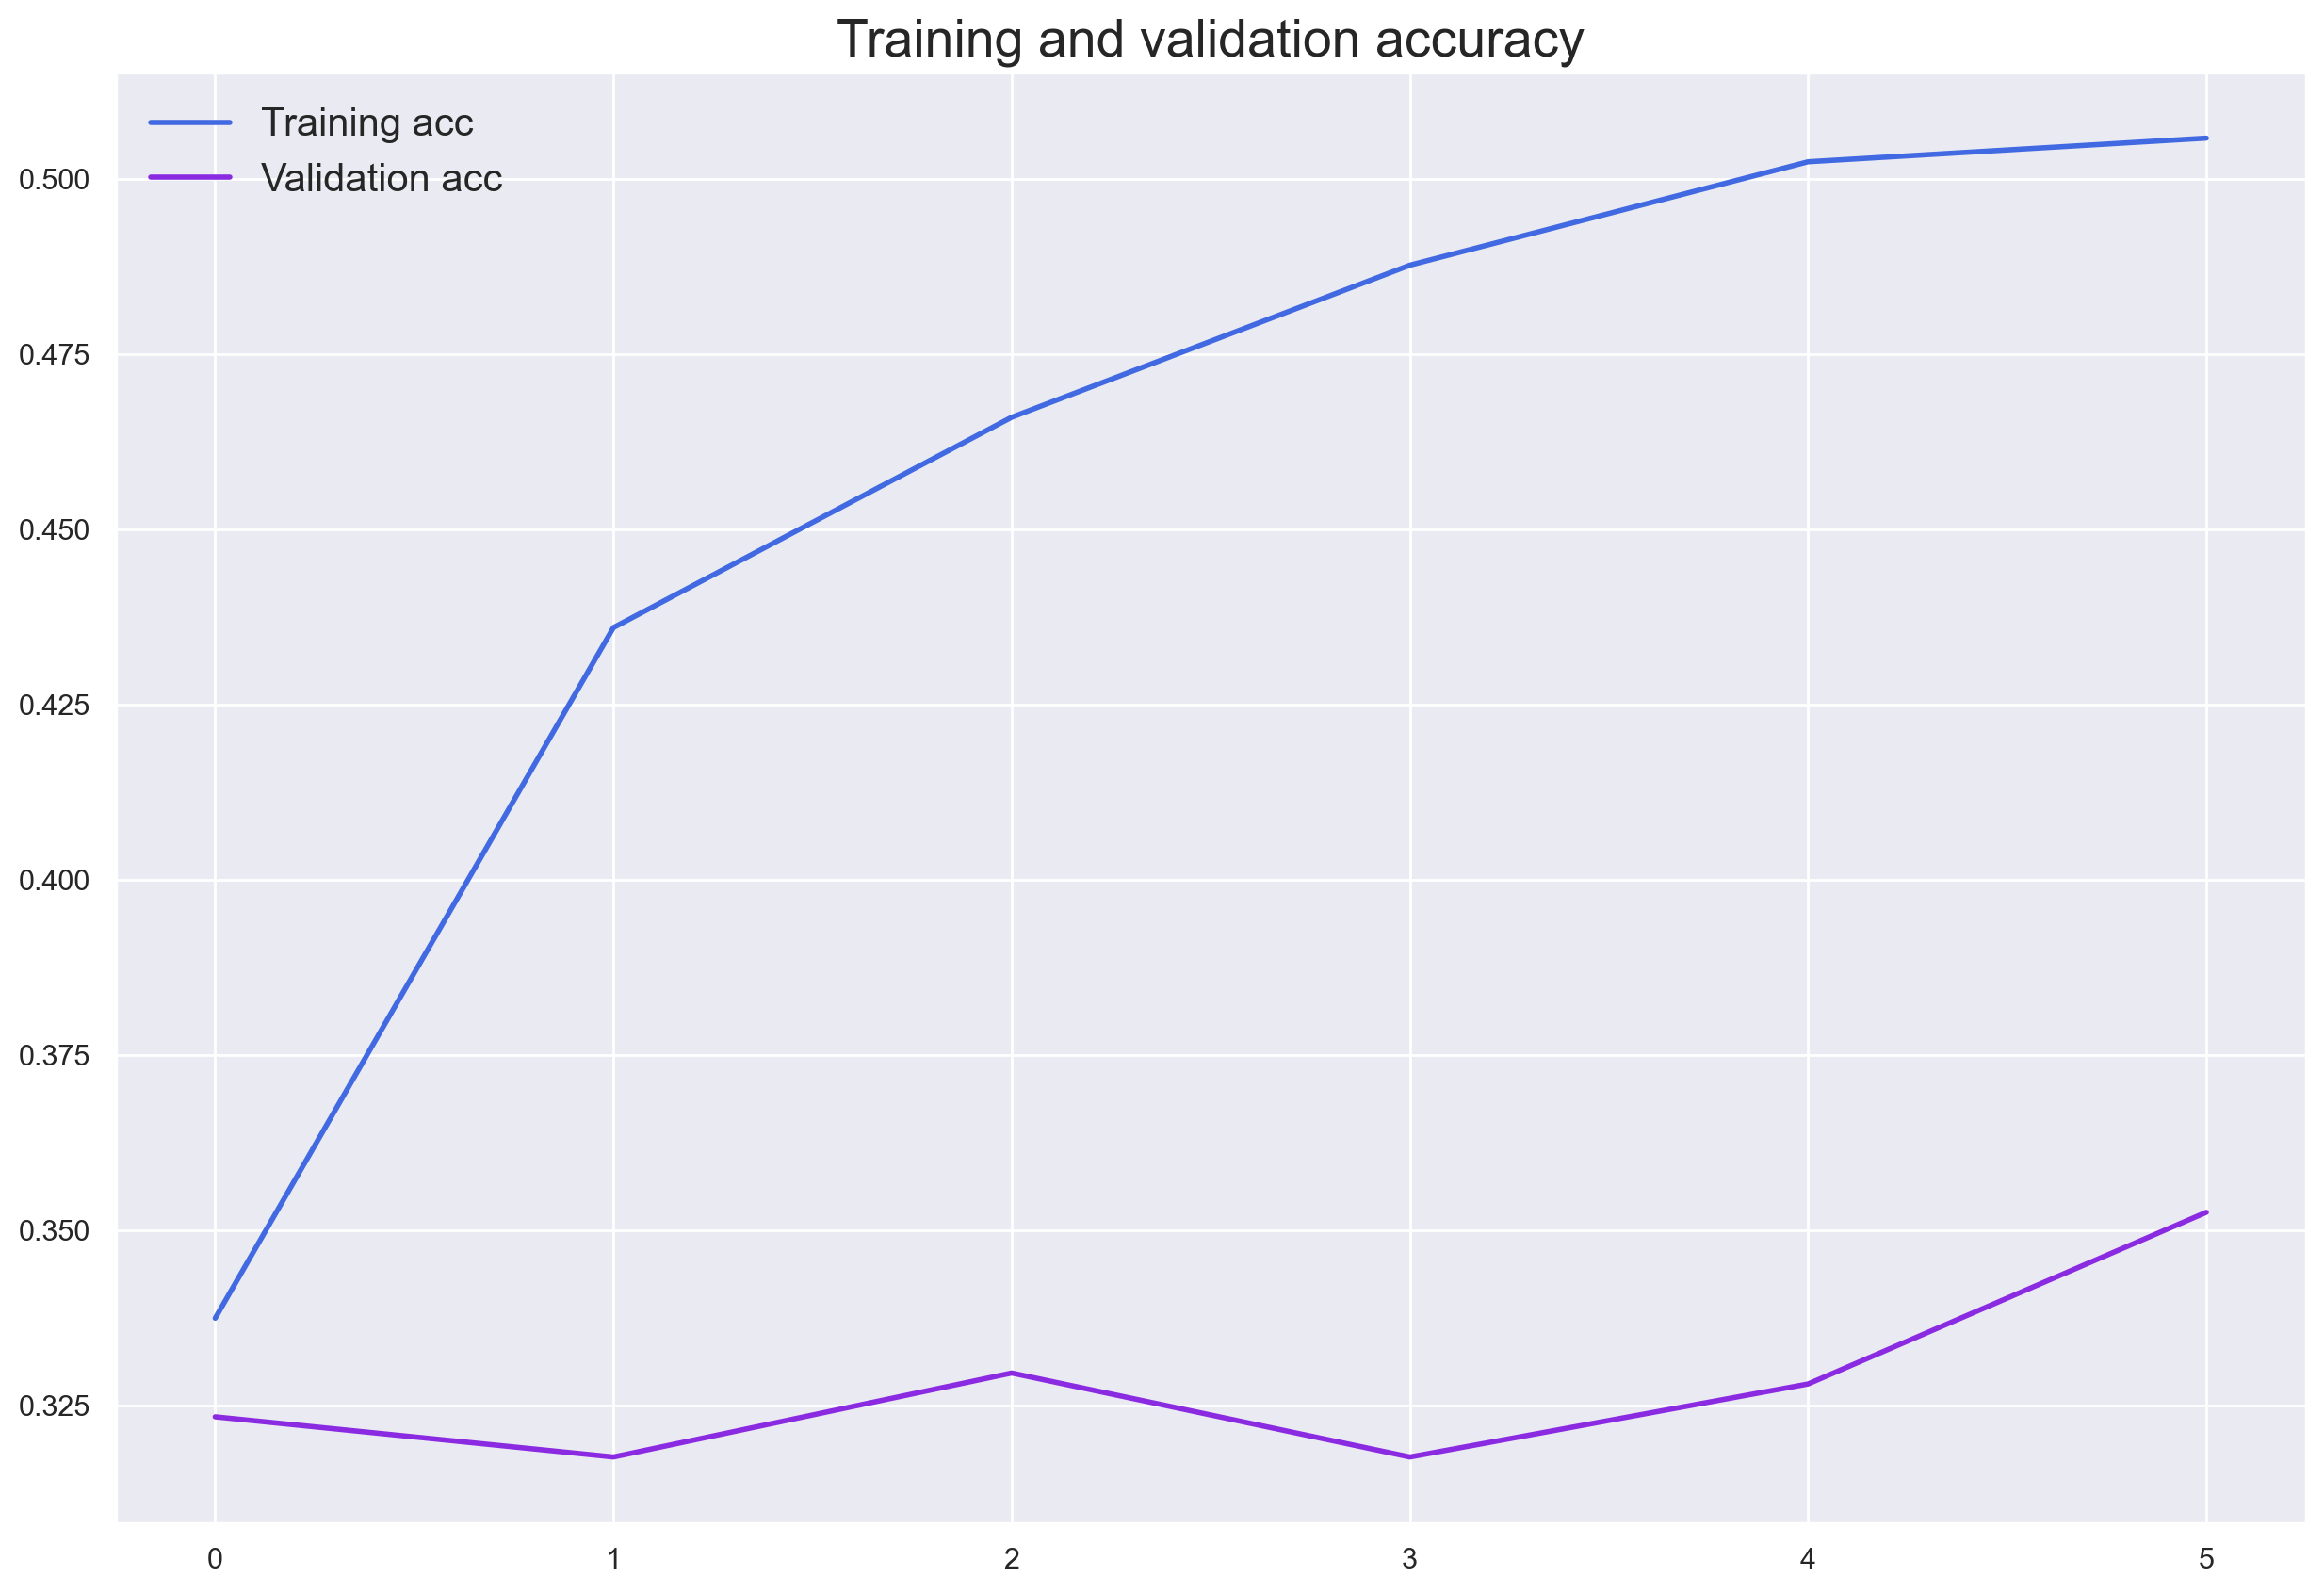

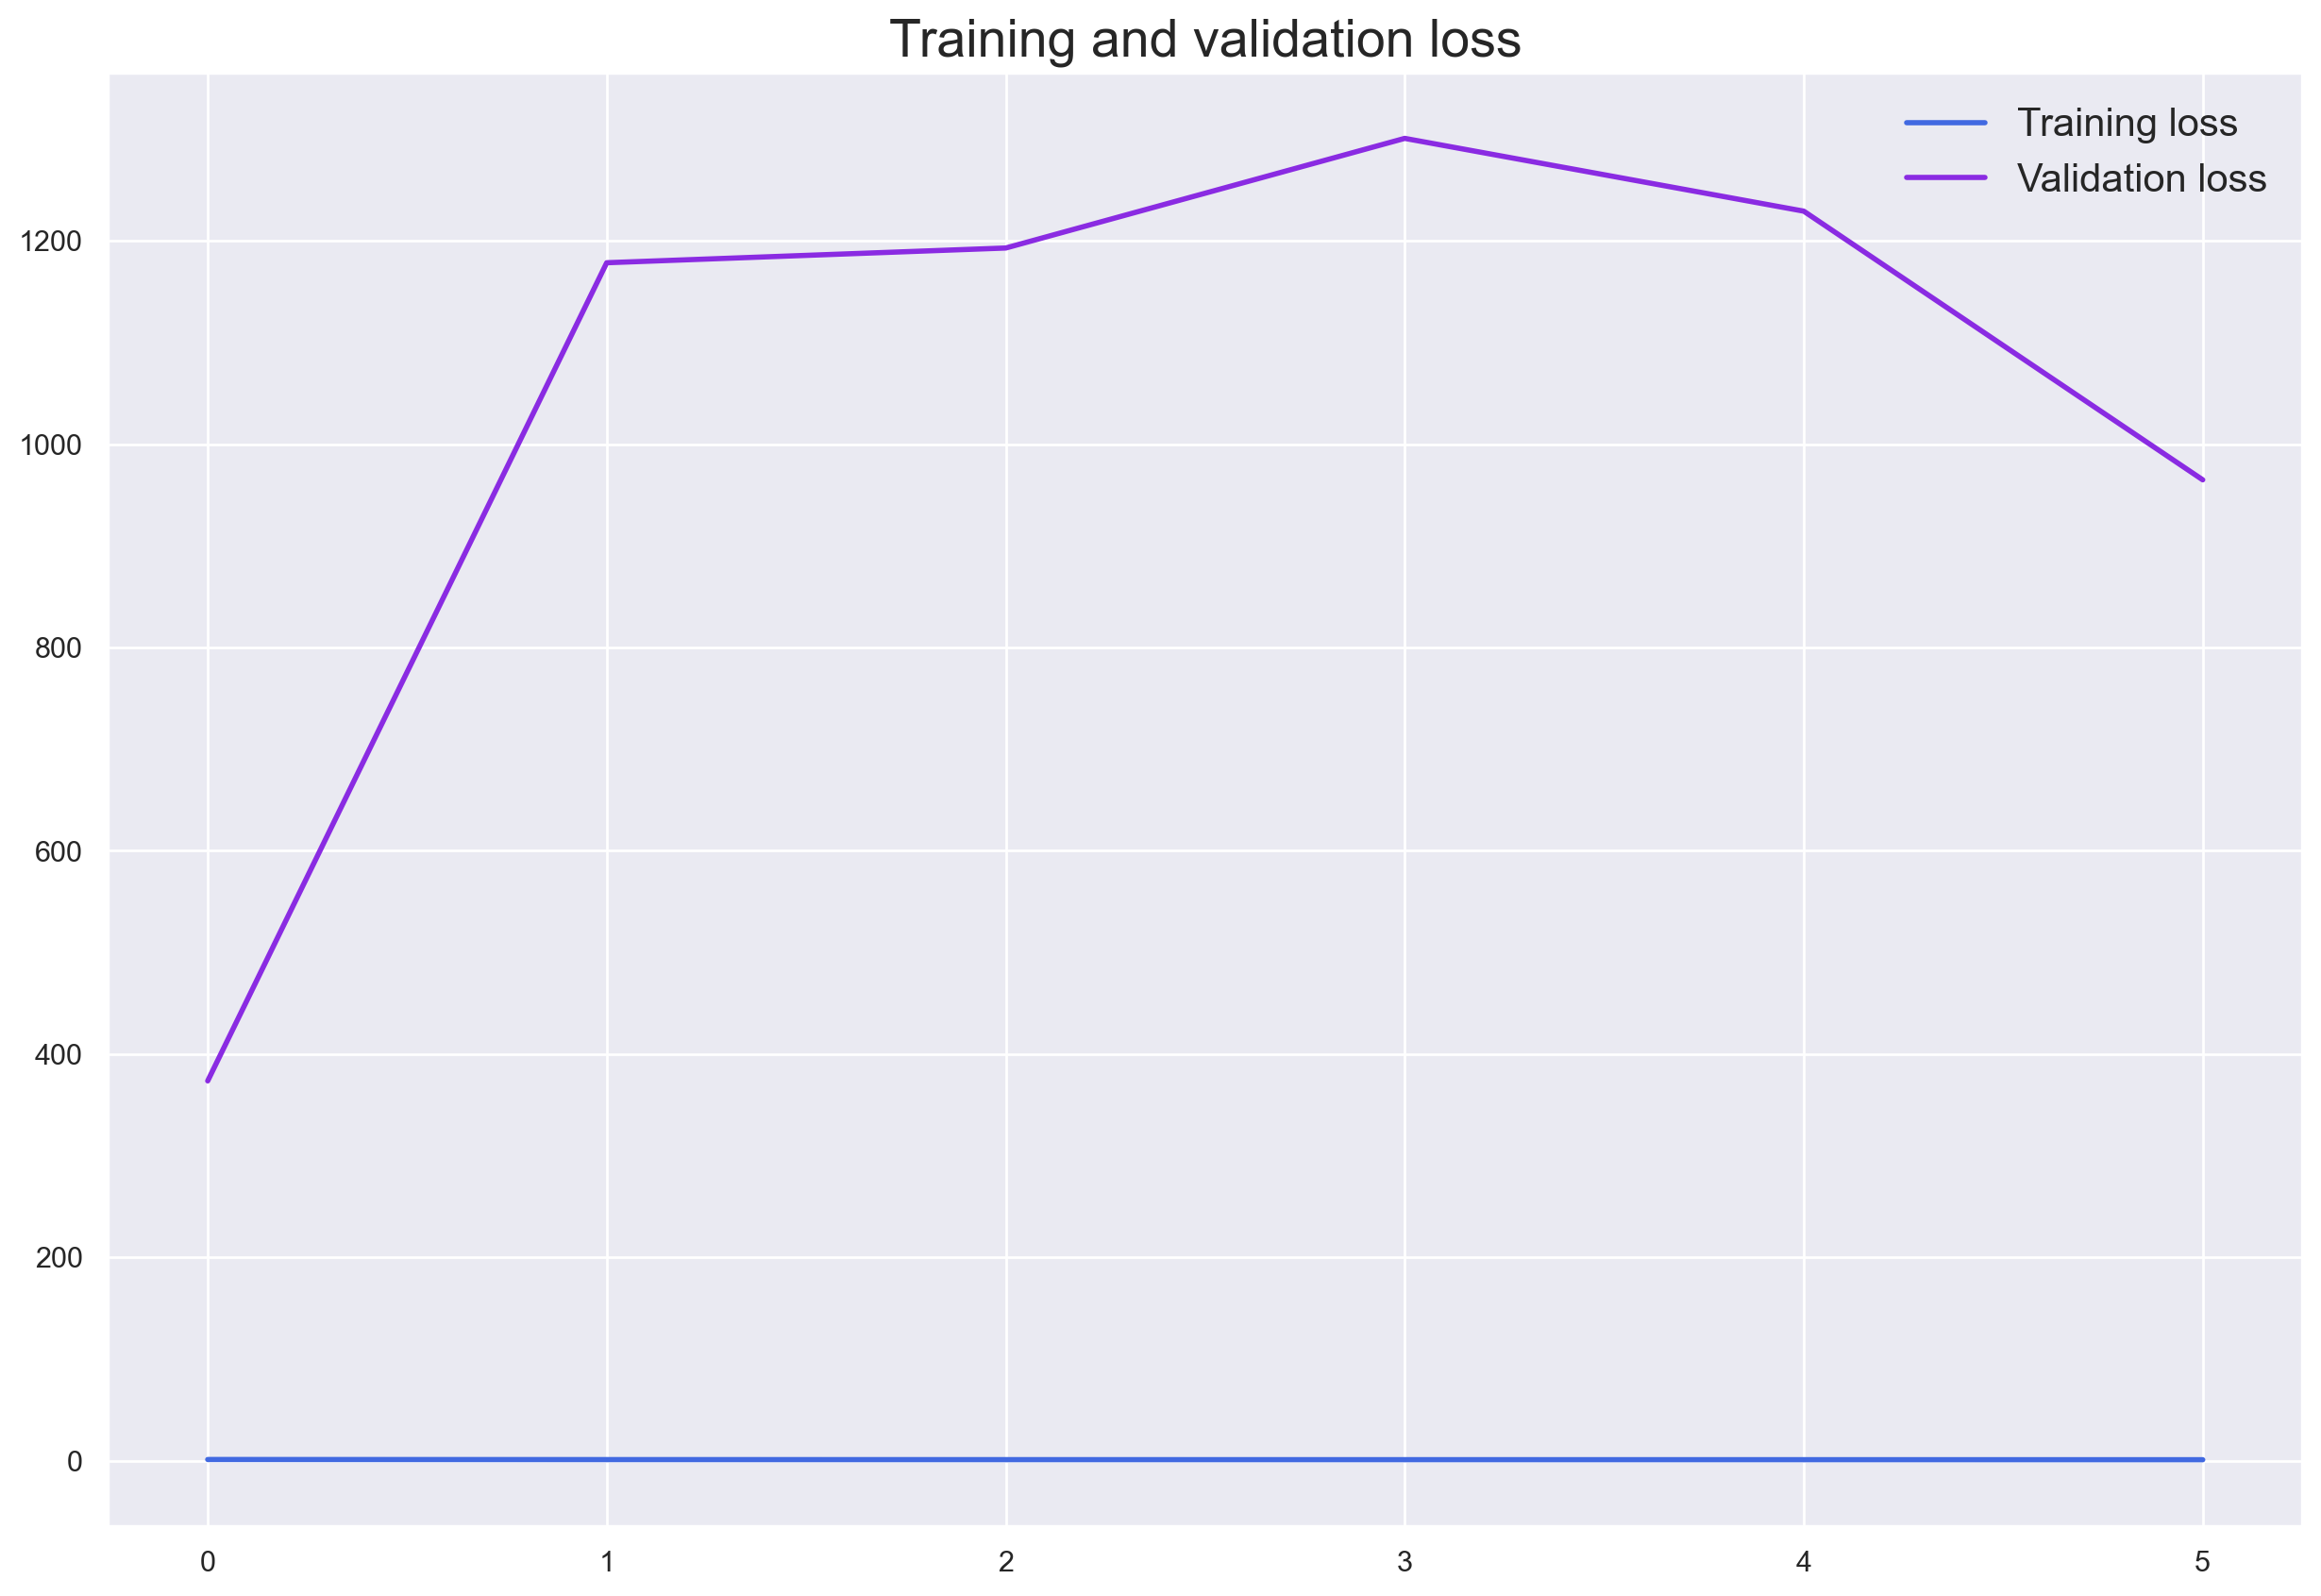

In [68]:
sns.set_theme()

plt.figure(figsize=(15,10), dpi=200)

plt.plot(epochs, acc, 'royalblue', linewidth=2, label='Training acc')
plt.plot(epochs, val_acc, 'blueviolet', linewidth=2, label='Validation acc')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend(frameon=False, fontsize=15)

plt.show()

plt.figure(figsize=(15,10), dpi=200)

plt.plot(epochs, loss, 'royalblue', linewidth=2, label='Training loss')
plt.plot(epochs, val_loss, 'blueviolet', linewidth=2, label='Validation loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend(frameon=False, fontsize=15)

plt.show()

In [69]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=128,
        class_mode='categorical'
        )

Found 2000 images belonging to 4 classes.


In [70]:
model.evaluate(test_generator)

16/16 [==============================] - 47s 3s/step - loss: 1293.2188 - acc: 0.3230


[1293.21875, 0.3230000138282776]

As we can see, changing base architecture did not improve our model, but rather contributed to worsen performance. This may be due to the fact that this architecture is way more complex than the one we were using, which probably caused more overfitting to the data and a slower training process that prevented us from converging to a greater solution.